In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report

transaction_time: дата и время совершения транзакции \
merch: название или идентификатор продавца или торговой точки, где была совершена транзакция \
cat_id: идентификатор категории товара или услуги, к которой относится транзакция \
amount: сумма транзакции \
name_1, name_2: имена, связанные с транзакцией \
gender: пол клиента \
street: название улицы \
one_city: город \
us_state: штат США \
post_code: почтовый индекс \
lat, lon: широта и долгота \
population_city: численность населения города проживания клиента \
jobs: уровень занятости \
merchant_lat, merchant_lon: широта и долгота местоположения продавца или точки продажи \
target: целевая переменная

## EDA

In [167]:
df = pd.read_csv('train.csv')

In [168]:
# df.head(3)

In [169]:
df.duplicated().sum() # Колво дубликатов

0

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786431 entries, 0 to 786430
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_time  786431 non-null  object 
 1   merch             786431 non-null  object 
 2   cat_id            786431 non-null  object 
 3   amount            786431 non-null  float64
 4   name_1            786431 non-null  object 
 5   name_2            786431 non-null  object 
 6   gender            786431 non-null  object 
 7   street            786431 non-null  object 
 8   one_city          786431 non-null  object 
 9   us_state          786431 non-null  object 
 10  post_code         786431 non-null  int64  
 11  lat               786431 non-null  float64
 12  lon               786431 non-null  float64
 13  population_city   786431 non-null  int64  
 14  jobs              786431 non-null  object 
 15  merchant_lat      786431 non-null  float64
 16  merchant_lon      78

In [17]:
df.describe()

,amount,post_code,lat,lon,population_city,merchant_lat,merchant_lon,target
count,786431.000000,786431.000000,786431.000000,786431.000000,7.864310e+05,786431.000000,786431.000000,786431.000000
mean,70.241296,48802.521336,38.527972,-90.224069,8.928853e+04,38.527301,-90.224508,0.005727
std,161.091489,26896.564152,5.078756,13.754760,3.028600e+05,5.113222,13.766977,0.075461
min,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,19.027804,-166.670132,0.000000
25%,9.650000,26237.000000,34.620500,-96.798000,7.430000e+02,34.727480,-96.901593,0.000000
50%,47.410000,48174.000000,39.346500,-87.476900,2.456000e+03,39.357665,-87.436919,0.000000
75%,83.000000,72042.000000,41.894800,-80.158000,2.047800e+04,41.950609,-80.233429,0.000000
max,27390.120000,99783.000000,66.693300,-67.950300,2.906700e+06,67.441518,-66.955996,1.000000


**Дубликатов нет \
Null нет \
Среди колонок вижу время - можно юзать тригонометрию**

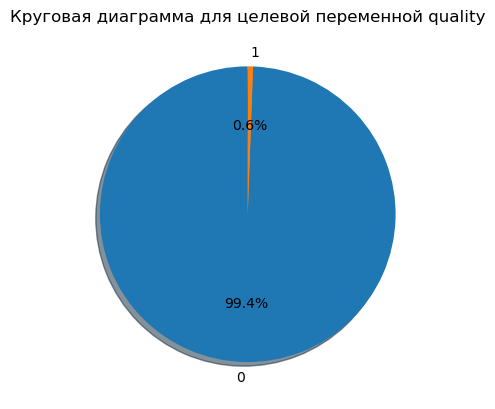

In [22]:
plt.pie(x=df['target'].value_counts().values,
        labels=df['target'].value_counts().index,
        startangle=90,
        autopct='%1.1f%%',
        shadow=True
       )
plt.title(f'Круговая диаграмма для целевой переменной quality')
plt.show()

**Ну как и ожидалось лютый дисбаланс, в процессе обучения можно будет давать бОльший вес классу 1**

In [26]:
def classify_columns(df):
    numeric_columns = []
    categorical_columns = []

    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            numeric_columns.append(column)
        else:
            categorical_columns.append(column)

    return numeric_columns, categorical_columns

numeric_columns, categorical_columns = classify_columns(df)

print("Числовые колонки:", numeric_columns)
print("Категориальные колонки:", categorical_columns)

Числовые колонки: ['amount', 'post_code', 'lat', 'lon', 'population_city', 'merchant_lat', 'merchant_lon', 'target']
Категориальные колонки: ['transaction_time', 'merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'jobs']


**Быстро глянем, на какой скор рассчитывать, если вообще не париться:**

In [58]:
# X = df.drop('target', axis=1)
# y = df['target']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# cat_features = ['transaction_time', 'merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'jobs']

# train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
# test_pool = Pool(X_test, label=y_test, cat_features=cat_features)

# model = CatBoostClassifier(iterations=1000, random_state=42, verbose=100)
# model.fit(train_pool)

# y_pred = model.predict(test_pool)

# print("Classification Report:")
# print(classification_report(y_test, y_pred))

**0.77 f1_score без преднастройки, причем проседает recall.. возвращаемся к EDA**
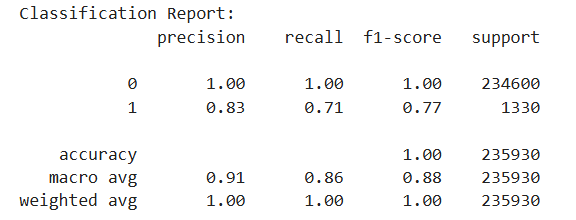

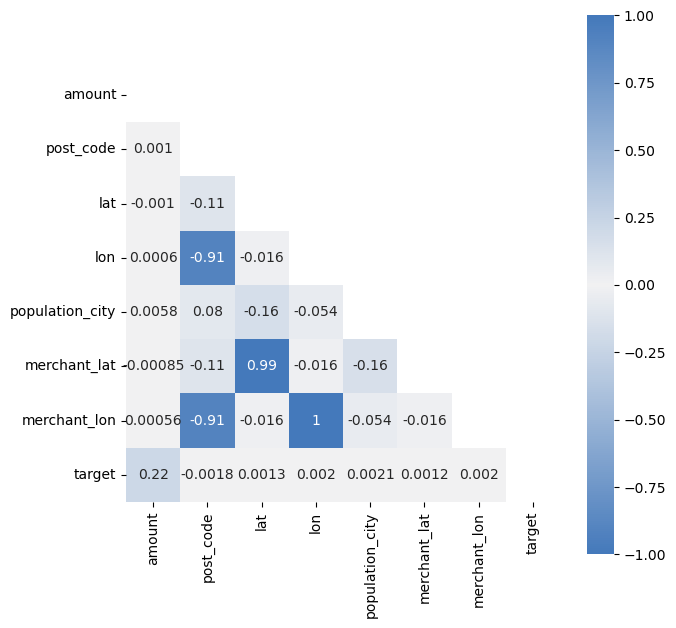

In [50]:
corr = df.drop(['transaction_time', 'merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'jobs'], axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(corr,
    mask=mask,
    cmap=sns.diverging_palette(250, 250, as_cmap=True),
    annot = True,
    vmin=-1.0, vmax=1.0, # всегда ставить от -1 до 1 ставим два одинаковых цвета на оба конца
    square=True,
    ax=ax);

**Видим прикольную мультиколлинеарность, но она тоже ожидаема**

In [175]:
print("Размерность датафрейма:")
print(df.shape)
print()
missing_values_count = df.isna().sum()  # Общее количество пропущенных значений
missing_values_percentage = (df.isna().mean() * 100).round(2)  # Процент пропущенных значений
unique_values_count = df.nunique()  # Количество уникальных значений в каждом столбце

missing_summary = pd.DataFrame({
    # 'Missing Values Count': missing_values_count,
    # 'Missing Values Percentage': missing_values_percentage,
    'Unique Values Count': unique_values_count
})

print("Сводка по отсутствующим значениям и уникальным значениям:")
print(missing_summary)

Размерность датафрейма:
(786431, 18)

Сводка по отсутствующим значениям и уникальным значениям:
                  Unique Values Count
transaction_time               419851
merch                             693
cat_id                             14
amount                          43385
name_1                            348
name_2                            479
gender                              2
street                            965
one_city                          879
us_state                           51
post_code                         952
lat                               950
lon                               951
population_city                   865
jobs                              493
merchant_lat                   768221
merchant_lon                   778745
target                              2


In [67]:
# plot_cols = df.drop('target', axis=1).columns # выкидываем целевую переменную, она не нужна для боксплота
# n_cols = 3  
# n_rows = (len(plot_cols) + n_cols - 1) // n_cols  # расчет кол-ва строк
# fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(18, n_rows * 5))

# ax = ax.flatten() # превращает двумерный массив осей (ax), созданный под n_cols и n_rows, в одномерный массив, 
# # чтобы к ним было проще обращаться по индексу.

# for index, col in enumerate(plot_cols):
#     sns.boxplot(y=col, data=df, ax=ax[index], hue='target')

# for empty_ax in ax[len(plot_cols):]:
#     empty_ax.set_visible(False)

# plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
# plt.show()

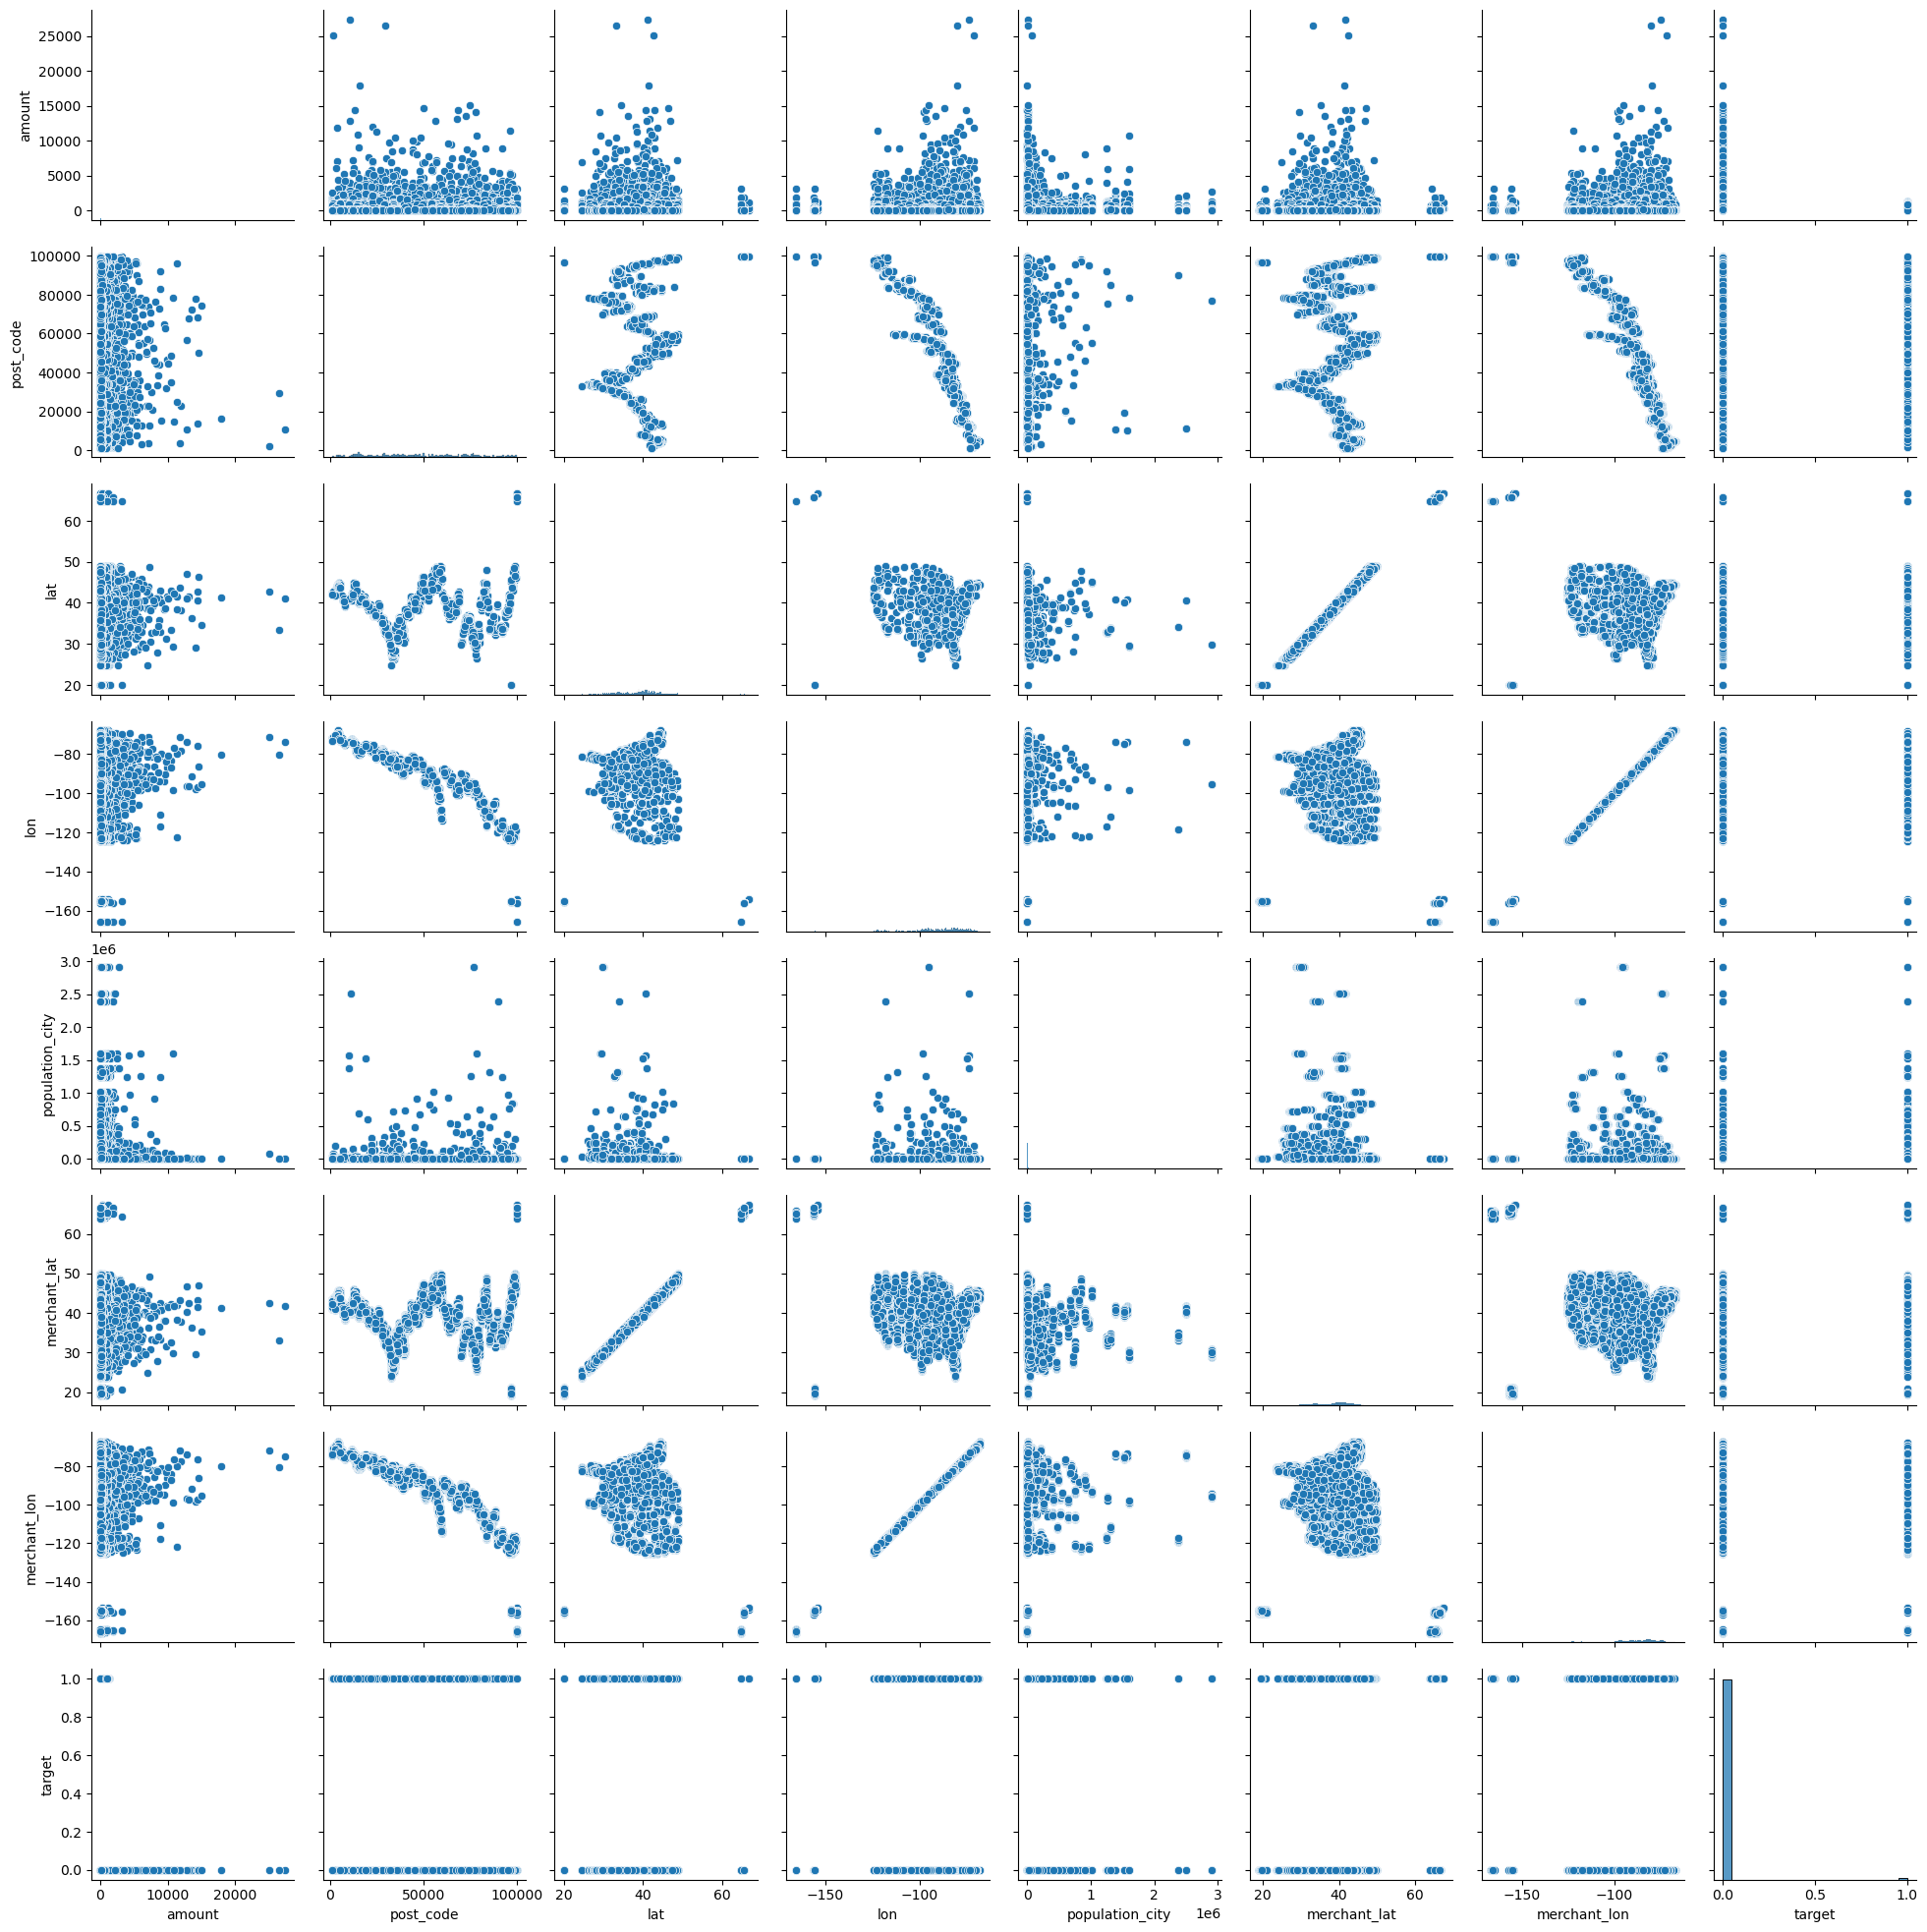

In [69]:
sns.pairplot(df)

На некоторых графиках вроде может показаться что есть аномалии, \
но думаю что точки выбивающеся из общей совокупности, в теории могут существовать и все ок

In [177]:
df

,transaction_time,merch,cat_id,amount,name_1,name_2,gender,street,one_city,us_state,post_code,lat,lon,population_city,jobs,merchant_lat,merchant_lon,target
0,2019-12-27 15:21,fraud_Cormier LLC,health_fitness,148.04,Daniel,Martinez,M,8510 Acevedo Burgs,Kent,OR,97033,45.0838,-120.6649,60,Museum education officer,45.042827,-120.709327,0
1,2019-04-17 23:09,"fraud_Brown, Homenick and Lesch",health_fitness,39.40,Grace,Williams,F,28812 Charles Mill Apt. 628,Plantersville,AL,36758,32.6176,-86.9475,1412,Drilling engineer,31.872266,-87.828247,0
2,2019-09-23 15:02,fraud_Ruecker-Mayert,kids_pets,52.96,Kyle,Park,M,7507 Larry Passage Suite 859,Mount Perry,OH,43760,39.8788,-82.1880,1831,Barrister's clerk,40.010874,-81.841249,0
3,2019-05-13 16:00,"fraud_Mante, Luettgen and Hackett",health_fitness,7.66,Monique,Martin,F,68276 Matthew Springs,Ratcliff,TX,75858,31.3833,-95.0619,43,"Engineer, production",30.888406,-95.141609,0
4,2019-08-18 07:27,fraud_Luettgen PLC,gas_transport,51.59,Christine,Johnson,F,8011 Chapman Tunnel Apt. 568,Blairsden-Graeagle,CA,96103,39.8127,-120.6405,1725,Chartered legal executive (England and Wales),39.376017,-121.311691,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786426,2019-04-10 12:35,"fraud_O'Connell, Botsford and Hand",home,76.56,Ryan,Foster,M,03921 Cole Mission Suite 882,Hampton,FL,32044,29.8575,-82.1483,2060,Oncologist,29.235257,-82.407844,0
786427,2019-12-15 09:34,"fraud_Adams, Kovacek and Kuhlman",grocery_net,68.58,Jim,Johnson,M,868 Brady Mill Apt. 837,Gretna,LA,70056,29.8872,-90.0331,55581,Biomedical scientist,29.015274,-90.564712,0
786428,2019-10-12 10:22,"fraud_Lind, Huel and McClure",gas_transport,66.66,Christopher,Horn,M,956 Sanchez Highway,Mallie,KY,41836,37.2692,-82.9161,798,Facilities manager,37.515508,-82.443788,0
786429,2019-10-18 09:01,fraud_Rempel PLC,grocery_net,38.06,Samuel,Sandoval,M,0005 Morrison Land,Mounds,OK,74047,35.8896,-96.0887,7163,Fitness centre manager,35.203864,-96.999902,0


In [179]:
selected_columns = ['lat', 'lon', 'merchant_lat', 'merchant_lon']

for column in selected_columns:
    max_value = df[column].max()
    min_value = df[column].min()
    print(f"Колонка: {column}")
    print(f"Максимальное значение: {max_value}")
    print(f"Минимальное значение: {min_value}")
    print("-" * 30)

# все ок

Колонка: lat
Максимальное значение: 66.6933
Минимальное значение: 20.0271
------------------------------
Колонка: lon
Максимальное значение: -67.9503
Минимальное значение: -165.6723
------------------------------
Колонка: merchant_lat
Максимальное значение: 67.441518
Минимальное значение: 19.027804
------------------------------
Колонка: merchant_lon
Максимальное значение: -66.955996
Минимальное значение: -166.670132
------------------------------


финальные идеи: \
добавить тригонометрию на даты \
выделить секунды / минуты / часы / дни \
думать насчет борьбы с мультиколлинеарностью \
бороться с дисбалансом \
фичи инжинеринг \
для простых моделей нужен препроцесинг (только масштабирование тк null нет), для лесов не надо \
юзаем разные модели (только SVM не надо, иначе я быстрее на пенсию выйду) \
настройка гп разумеется

## Preprocessing

In [183]:
# df
df['transaction_time'] = pd.to_datetime(df['transaction_time'])

# df['seconds'] = df['transaction_time'].dt.second
df['minutes'] = df['transaction_time'].dt.minute
df['hours'] = df['transaction_time'].dt.hour
df['days'] = df['transaction_time'].dt.day
df['month'] = df['transaction_time'].dt.month
df['year'] = df['transaction_time'].dt.year

In [185]:
df['hour_sin'] = np.sin(2 * np.pi * df['hours'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hours'] / 24)

df['day_sin'] = np.sin(2 * np.pi * df['days'] / 30) 
df['day_cos'] = np.cos(2 * np.pi * df['days'] / 30)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# df['year_sin'] = np.sin(2 * np.pi * (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min() + 1))
# df['year_cos'] = np.cos(2 * np.pi * (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min() + 1))

In [192]:
df = df.drop('transaction_time', axis=1)

In [202]:
df = df.drop(['lon', 'lat', 'post_code'], axis=1)

In [204]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

cat_features = ['merch', 'cat_id', 'name_1', 'name_2', 'gender', 'street', 'one_city', 'us_state', 'jobs']

train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(iterations=300, verbose=50)
model.fit(train_pool)

y_pred = model.predict(test_pool)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Learning rate set to 0.459957
0:	learn: 0.0727910	total: 304ms	remaining: 1m 31s
50:	learn: 0.0052203	total: 17.1s	remaining: 1m 23s
100:	learn: 0.0038202	total: 34.9s	remaining: 1m 8s
150:	learn: 0.0030318	total: 55.4s	remaining: 54.6s
200:	learn: 0.0024609	total: 1m 13s	remaining: 36.3s
250:	learn: 0.0020898	total: 1m 33s	remaining: 18.2s
299:	learn: 0.0017632	total: 1m 51s	remaining: 0us
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    234579
           1       0.96      0.85      0.90      1351

    accuracy                           1.00    235930
   macro avg       0.98      0.93      0.95    235930
weighted avg       1.00      1.00      1.00    235930



In [207]:
df_test = pd.read_csv('test.csv')